In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor


***Data Dividing***

In [3]:
import glob

chasedb1_path = '/media/mountHDD2/chasedb1'

image_files = glob.glob(chasedb1_path + '/*.jpg')
mask_files = glob.glob(chasedb1_path + '/*1stHO.png')

image_files.sort()
mask_files.sort()

img_dir = []
mask_dir = []

# Tạo danh sách các cặp (image, mask)
image_mask_pairs = [(image, mask) for image, mask in zip(image_files, mask_files)]

for pair in image_mask_pairs:
    img_dir.append(pair[0])  
    mask_dir.append(pair[1]) 

In [4]:
img_dir

['/media/mountHDD2/chasedb1/Image_01L.jpg',
 '/media/mountHDD2/chasedb1/Image_01R.jpg',
 '/media/mountHDD2/chasedb1/Image_02L.jpg',
 '/media/mountHDD2/chasedb1/Image_02R.jpg',
 '/media/mountHDD2/chasedb1/Image_03L.jpg',
 '/media/mountHDD2/chasedb1/Image_03R.jpg',
 '/media/mountHDD2/chasedb1/Image_04L.jpg',
 '/media/mountHDD2/chasedb1/Image_04R.jpg',
 '/media/mountHDD2/chasedb1/Image_05L.jpg',
 '/media/mountHDD2/chasedb1/Image_05R.jpg',
 '/media/mountHDD2/chasedb1/Image_06L.jpg',
 '/media/mountHDD2/chasedb1/Image_06R.jpg',
 '/media/mountHDD2/chasedb1/Image_07L.jpg',
 '/media/mountHDD2/chasedb1/Image_07R.jpg',
 '/media/mountHDD2/chasedb1/Image_08L.jpg',
 '/media/mountHDD2/chasedb1/Image_08R.jpg',
 '/media/mountHDD2/chasedb1/Image_09L.jpg',
 '/media/mountHDD2/chasedb1/Image_09R.jpg',
 '/media/mountHDD2/chasedb1/Image_10L.jpg',
 '/media/mountHDD2/chasedb1/Image_10R.jpg',
 '/media/mountHDD2/chasedb1/Image_11L.jpg',
 '/media/mountHDD2/chasedb1/Image_11R.jpg',
 '/media/mountHDD2/chasedb1/Imag

In [5]:
mask_dir

['/media/mountHDD2/chasedb1/Image_01L_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_01R_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_02L_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_02R_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_03L_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_03R_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_04L_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_04R_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_05L_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_05R_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_06L_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_06R_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_07L_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_07R_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_08L_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_08R_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_09L_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_09R_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_10L_1stHO.png',
 '/media/mountHDD2/chasedb1/Image_10R_1stHO.png',


In [6]:
print(len(img_dir),len(mask_dir))

28 28


***Custorm Dataset***


In [7]:
class ChasedbT(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, target_transform=None):
        self.imgs = img_dir  
        self.msks = mask_dir 
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

In [8]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        #transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #The mean and std of ImageNet,Medical images must be counted separately 
    ]
)
#https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

Data_transfered = ChasedbT( img_dir=img_dir, mask_dir=mask_dir,transform = transform, target_transform=target_transform)
print(len(Data_transfered))

28


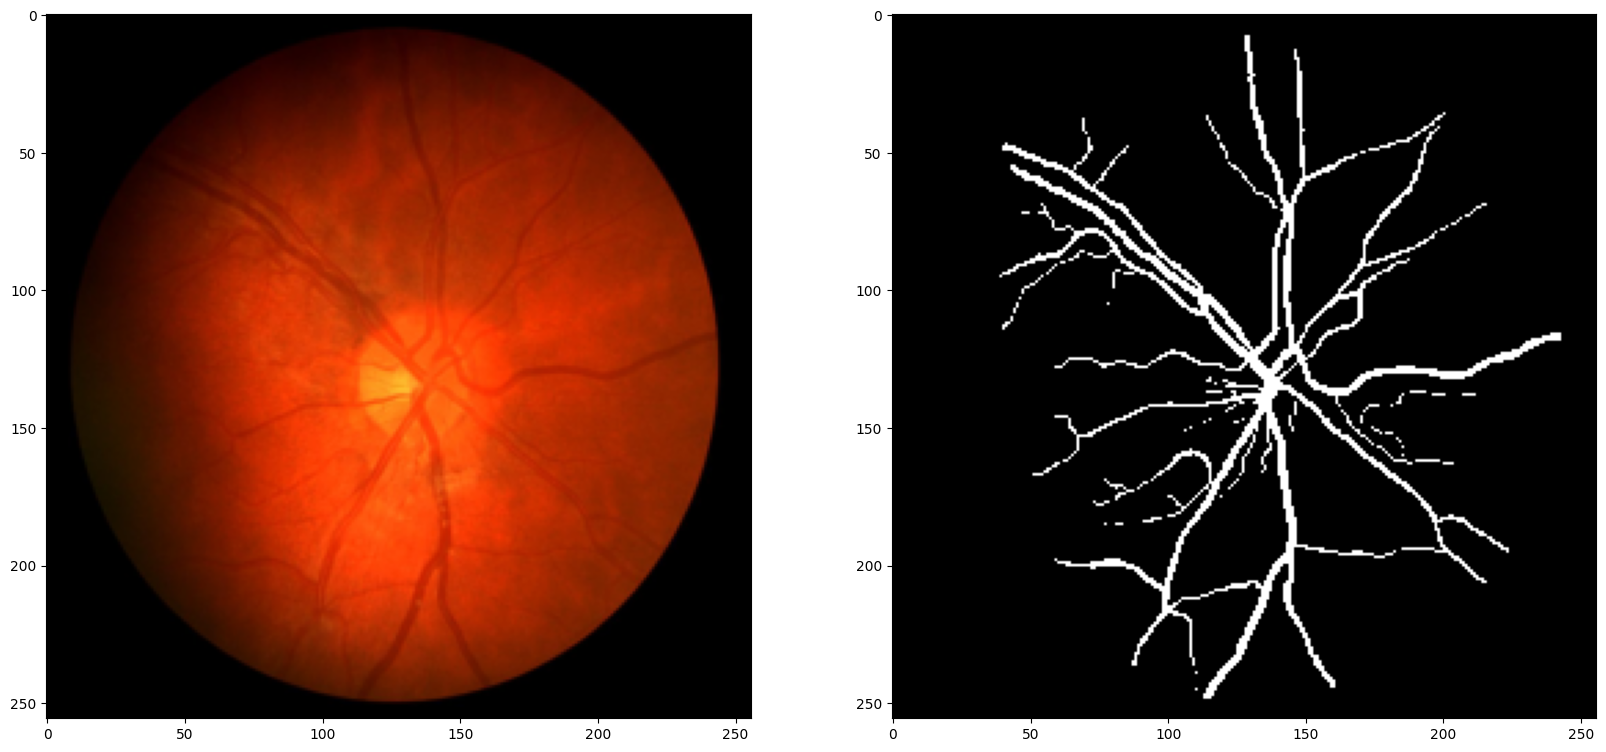

In [9]:

img, msk = Data_transfered[27]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20)) #tạo một figure chứa hai axes (ax1 và ax2) được sắp xếp theo hàng ngang với kích thước 20x20 inches
ax1.imshow(img.permute(1, -1, 0).numpy()) #Phương thức permute(1, -1, 0) được sử dụng để thay đổi chiều của tensor ,.numpy() chuyển đổi tensor thành mảng NumPy
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [9]:
from torch.utils.data.dataset import random_split
train_ds, test_ds = random_split(Data_transfered, [0.8, 0.2])

train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

print("Training Samples: {}".format(len(train_ds)))
print("Testing Samples: {}".format(len(test_ds)))

Training Samples: 23
Testing Samples: 5


In [10]:
sample_data, sample_mask = train_ds[10]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")

print(f"Number classes: {np.unique(sample_mask.numpy())}")

data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])
Number classes: [0. 1.]


In [11]:
msk.unique()

tensor([0., 1.])

***Training***

In [11]:
class Attention_block(nn.Module): #Module này giúp mô hình tập trung vào các đặc trưng quan trọng trong dữ liệu đầu vào.
    def __init__(self, F_g, F_l, F_int): #Khởi tạo các layer
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x): #Phương thức này thực hiện lan truyền thuận của dữ liệu qua module Attention.
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

In [12]:
class conv_block(nn.Module): #Xây dựng một module gồm hai lớp Convolutional Neural Networks (CNNs) được xếp chồng nhau, mỗi lớp gồm Convolution, Batch Normalization và ReLU.
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x


class up_conv(nn.Module): #Xây dựng một module thực hiện phép Upsampling (tăng kích thước) của đầu vào.
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [13]:
class AttU_Net(nn.Module):
    """https://arxiv.org/abs/1804.03999"""
    def __init__(self, img_ch=3, output_ch=3, ini_filter = 16):
        super(AttU_Net, self).__init__()

        n1 = ini_filter
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)        
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

In [14]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    #Hàm này tính toán hệ số Dice giữa dự đoán (input) và mục tiêu (target),được sử dụng để đánh giá độ tương đồng giữa hai mẫu dữ liệu nhị phân
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    #Hàm này tính toán hệ số Dice đa lớp cho từng lớp trong mô hình. Thường được sử dụng khi có nhiều lớp cần đánh giá
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    #Hàm này tính toán mất mát Dice, là giá trị cần tối thiểu hóa trong quá trình huấn luyện mô hình. Mất mát Dice được tính bằng công thức 1 - hệ số Dic
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [15]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)
device = torch.device("cpu")
model = AttU_Net(3,1,16).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = nn.BCEWithLogitsLoss()

In [19]:
old_loss = 1e26
best_dct = None
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()        
        
        tr_total_loss += train_loss.cpu().item()        
            
    mean_train_loss = tr_total_loss/len(train_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.10it/s]


Epoch: 0 - TrainLoss: 0.5259744887766631


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.14it/s]


Epoch: 1 - TrainLoss: 0.4582921240640723


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.09it/s]


Epoch: 2 - TrainLoss: 0.4101591291634933


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.19it/s]


Epoch: 3 - TrainLoss: 0.3630756800589354


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  7.92it/s]


Epoch: 4 - TrainLoss: 0.31940991982169775


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.73it/s]


Epoch: 5 - TrainLoss: 0.27792489787806635


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.91it/s]


Epoch: 6 - TrainLoss: 0.23774237736411716


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.46it/s]


Epoch: 7 - TrainLoss: 0.20593193238196167


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.54it/s]


Epoch: 8 - TrainLoss: 0.17993351493192755


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.51it/s]


Epoch: 9 - TrainLoss: 0.15924732257490573


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  7.90it/s]


Epoch: 10 - TrainLoss: 0.1446188176455705


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.40it/s]


Epoch: 11 - TrainLoss: 0.13299096116553183


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.35it/s]


Epoch: 12 - TrainLoss: 0.12276587635278702


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.49it/s]


Epoch: 13 - TrainLoss: 0.11442517651164014


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.23it/s]


Epoch: 14 - TrainLoss: 0.10988140818865402


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.08it/s]


Epoch: 15 - TrainLoss: 0.1030241626760234


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.80it/s]


Epoch: 16 - TrainLoss: 0.09750548814949782


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.26it/s]


Epoch: 17 - TrainLoss: 0.09422516336907512


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.13it/s]


Epoch: 18 - TrainLoss: 0.08956692043853842


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.07it/s]


Epoch: 19 - TrainLoss: 0.0867926436273948


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.26it/s]


Epoch: 20 - TrainLoss: 0.08403876132291296


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  7.84it/s]


Epoch: 21 - TrainLoss: 0.08271282522574715


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.19it/s]


Epoch: 22 - TrainLoss: 0.07953353323366331


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.18it/s]


Epoch: 23 - TrainLoss: 0.07819798232420631


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.25it/s]


Epoch: 24 - TrainLoss: 0.07735997487021529


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.69it/s]


Epoch: 25 - TrainLoss: 0.07426065368496854


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.94it/s]


Epoch: 26 - TrainLoss: 0.07272183571172797


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.45it/s]


Epoch: 27 - TrainLoss: 0.07169303265602692


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  7.89it/s]


Epoch: 28 - TrainLoss: 0.07044793390061545


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.04it/s]


Epoch: 29 - TrainLoss: 0.06773263054049533


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.21it/s]


Epoch: 30 - TrainLoss: 0.06602088588735332


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.34it/s]


Epoch: 31 - TrainLoss: 0.06432065934590671


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.86it/s]


Epoch: 32 - TrainLoss: 0.06396778413782948


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.27it/s]


Epoch: 33 - TrainLoss: 0.06369036274111789


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.61it/s]


Epoch: 34 - TrainLoss: 0.06231946773503138


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.44it/s]


Epoch: 35 - TrainLoss: 0.06024784918712533


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.62it/s]


Epoch: 36 - TrainLoss: 0.05958063787092333


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  7.87it/s]


Epoch: 37 - TrainLoss: 0.060376421588918434


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.88it/s]


Epoch: 38 - TrainLoss: 0.061708003282547


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  7.96it/s]


Epoch: 39 - TrainLoss: 0.058327980177557984


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.24it/s]


Epoch: 40 - TrainLoss: 0.0546838186033394


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.45it/s]


Epoch: 41 - TrainLoss: 0.05363436626351398


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.47it/s]


Epoch: 42 - TrainLoss: 0.05225269156305686


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.78it/s]


Epoch: 43 - TrainLoss: 0.051485117200924004


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.01it/s]


Epoch: 44 - TrainLoss: 0.050179498837046


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.02it/s]


Epoch: 45 - TrainLoss: 0.047856689147327255


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.82it/s]


Epoch: 46 - TrainLoss: 0.047950537470371826


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.88it/s]


Epoch: 47 - TrainLoss: 0.04752162989714871


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.83it/s]


Epoch: 48 - TrainLoss: 0.04562318519405697


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.89it/s]


Epoch: 49 - TrainLoss: 0.04494978487491608


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.29it/s]


Epoch: 50 - TrainLoss: 0.04428096342345943


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.76it/s]


Epoch: 51 - TrainLoss: 0.04422702526916628


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.40it/s]


Epoch: 52 - TrainLoss: 0.04271725727164227


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.20it/s]


Epoch: 53 - TrainLoss: 0.040957482936589615


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.10it/s]


Epoch: 54 - TrainLoss: 0.03943025766183501


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.27it/s]


Epoch: 55 - TrainLoss: 0.038471124661357506


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.21it/s]


Epoch: 56 - TrainLoss: 0.03746412062774534


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.65it/s]


Epoch: 57 - TrainLoss: 0.03750254343385282


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.42it/s]


Epoch: 58 - TrainLoss: 0.038230455035100815


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.50it/s]


Epoch: 59 - TrainLoss: 0.036798859905937446


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.51it/s]


Epoch: 60 - TrainLoss: 0.03594612888991833


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.21it/s]


Epoch: 61 - TrainLoss: 0.03349664029867753


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.68it/s]


Epoch: 62 - TrainLoss: 0.03338445552989193


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.58it/s]


Epoch: 63 - TrainLoss: 0.031994431482061096


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.68it/s]


Epoch: 64 - TrainLoss: 0.03135751600822677


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.87it/s]


Epoch: 65 - TrainLoss: 0.03064409295177978


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.12it/s]


Epoch: 66 - TrainLoss: 0.030598321605635727


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.06it/s]


Epoch: 67 - TrainLoss: 0.02867296248998331


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.27it/s]


Epoch: 68 - TrainLoss: 0.029930901592192444


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.63it/s]


Epoch: 69 - TrainLoss: 0.029451988637447357


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.07it/s]


Epoch: 70 - TrainLoss: 0.03026084277940833


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.61it/s]


Epoch: 71 - TrainLoss: 0.028036810214752735


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.70it/s]


Epoch: 72 - TrainLoss: 0.02633611679725025


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.82it/s]


Epoch: 73 - TrainLoss: 0.024403276326863663


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.29it/s]


Epoch: 74 - TrainLoss: 0.02383411829562291


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.37it/s]


Epoch: 75 - TrainLoss: 0.022835835490537727


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.02it/s]


Epoch: 76 - TrainLoss: 0.022069419936641403


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.35it/s]


Epoch: 77 - TrainLoss: 0.02217558228775211


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.69it/s]


Epoch: 78 - TrainLoss: 0.02520393685478231


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.62it/s]


Epoch: 79 - TrainLoss: 0.02438772639826588


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.52it/s]


Epoch: 80 - TrainLoss: 0.022685638669392338


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.56it/s]


Epoch: 81 - TrainLoss: 0.022453696750428364


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.24it/s]


Epoch: 82 - TrainLoss: 0.020965742757139


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.58it/s]


Epoch: 83 - TrainLoss: 0.019735686157060707


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.43it/s]


Epoch: 84 - TrainLoss: 0.018460931013459744


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.18it/s]


Epoch: 85 - TrainLoss: 0.01765057108486476


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.23it/s]


Epoch: 86 - TrainLoss: 0.018409266258063522


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.21it/s]


Epoch: 87 - TrainLoss: 0.01901352235480495


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.36it/s]


Epoch: 88 - TrainLoss: 0.018764100037515163


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.84it/s]


Epoch: 89 - TrainLoss: 0.018918756800501244


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.45it/s]


Epoch: 90 - TrainLoss: 0.020010330876254517


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.19it/s]


Epoch: 91 - TrainLoss: 0.02014276729491742


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.48it/s]


Epoch: 92 - TrainLoss: 0.0168055332792194


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.48it/s]


Epoch: 93 - TrainLoss: 0.01470011387668226


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.53it/s]


Epoch: 94 - TrainLoss: 0.014052425308719925


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.39it/s]


Epoch: 95 - TrainLoss: 0.015150092258725477


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.13it/s]


Epoch: 96 - TrainLoss: 0.01646893127294986


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.72it/s]


Epoch: 97 - TrainLoss: 0.019310164751242035


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.19it/s]


Epoch: 98 - TrainLoss: 0.01958465195544388


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.99it/s]

Epoch: 99 - TrainLoss: 0.017055865701126015


<All keys matched successfully>

In [23]:
# Lưu parameters
torch.save(best_dct, 'parameter_attunet_v1.pth')

In [ ]:
#best_model = AttU_Net(3,1,16)  
#best_model.load_state_dict(torch.load('parameter_attunet_v1.pth'))

In [20]:
test_img_dir= '/home/chuyenmt/Chuyen_explore-Copy1/Test_Drive'

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


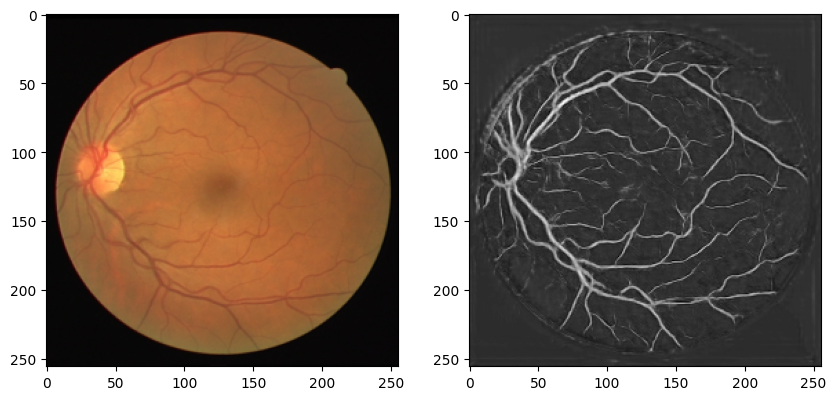

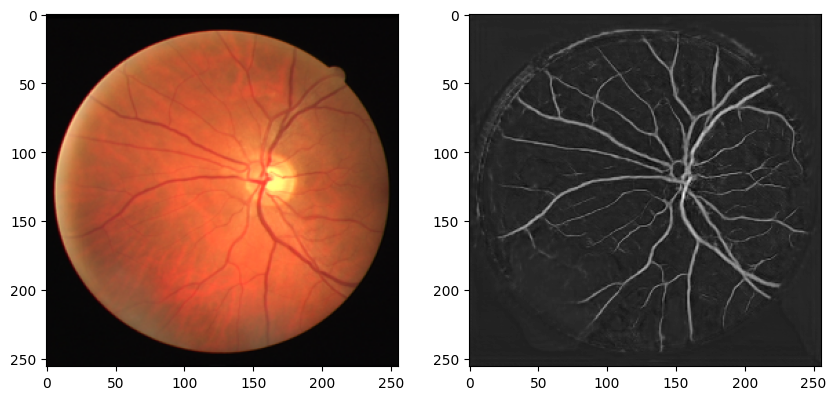

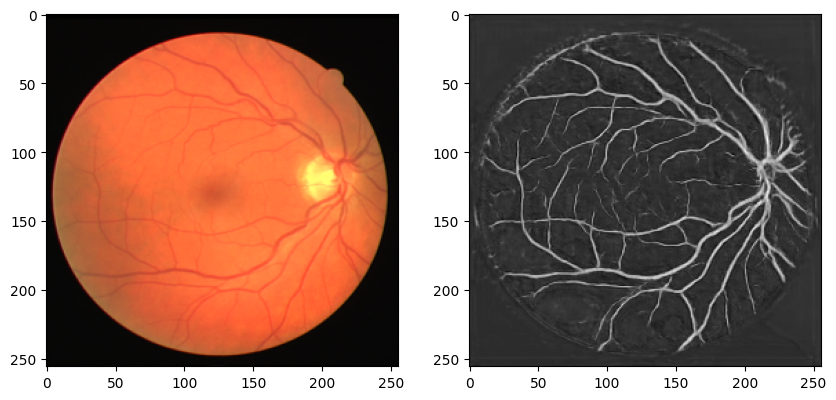

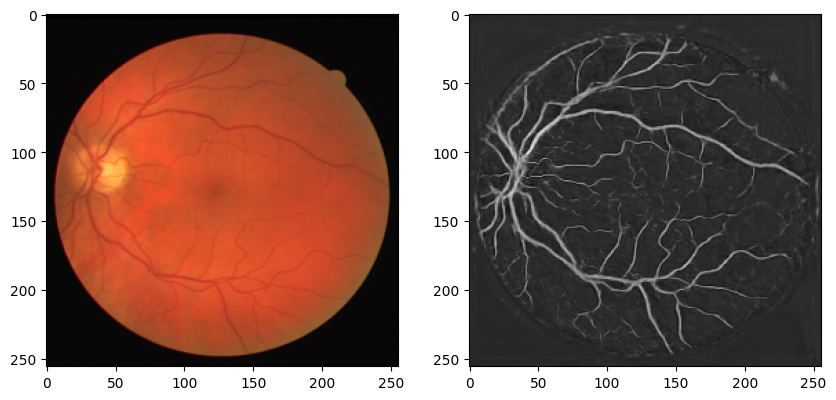

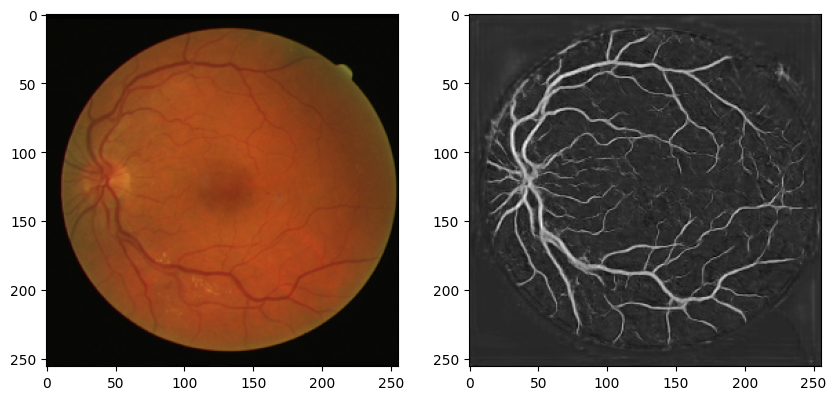

In [21]:
from glob import glob
for test_img_path in glob(test_img_dir + "/*"):
    img = transform(Image.open(test_img_path)).to(device).unsqueeze(0)

    mask = model(img)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(mask[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')
